# Lab 3: Hough Transform
## Computer Vision and Imaging
### Tariq Hawili, ID 2119640



# Task 1

"Work your way through the script. Using online documentation, understand how each function works, from edge detection, Hough Transform and line detection. Write a summary of how this algorithm works."

### 1. Imports
- Of course, we always begin by making the necessary imports. 

In [1]:
import sys
from skimage import io
from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage.transform import hough_line, hough_line_peaks
from skimage.color import rgb2gray
from skimage.feature import canny
from matplotlib import cm
import scipy.signal # To perform convolutions. 
from scipy.ndimage import label # For hysteresis. 
from numpy.typing import NDArray # Good SWE practice. 

### 2. Retrieve the image  convert it to grayscale. 
- After the imports, we want to retrieve our image from its source directory. 
- Since we'll be doing edge detection, we want our image in grayscale. This is because grayscale images contain information about the intensity of light emitted from a surface per unit area in a given direction, which is what we're interested in.
    - The weighting scheme used by skimage.color.rgb2gray is: $Y=0.2125R+0.7154G+0.0721B$
        - This formula is derived from the Rec. 709 standard, used in HDTV systems, which specifies the coefficients based on the human eye's sensitivity to the RGB colors. 
        - Since the green channel constitutes the majority of the weighting, sometimes it's all right just to extract the green channel. 

In [2]:
# Read image
img = io.imread('images/cluttera2.jpg')

# The image is RGB and we need to convert to grayscale
img_grey = rgb2gray(img)

### 3. Apply the Canny Edge Detection Algorithm

The Canny Edge detection algorithm is multi-stage algorithm that attempts to satisfy John Canny's $3$ criteria for edge detection:
1. Detection should accurately catch as many edges as possible with a low false positive and low false negative rate. 
2. The edge point that we detect should be the center of the edge--nothing more and nothing less. 
3. A given edge (the true edge) should be marked once and only once. 

Canny's algorithm is executed in $5$ steps and attempts to satisfy the above $3$ criteria:
1. Smooth the input image (which is in grayscale format at this point) using a Gaussian filter of appropriate size and $\sigma$. 
2. Compute the pixel gradients in the smoothed image. With them, calculate the magnitudes and directions of the pixel gradients.   
3. Non-maximum suppression: Using pixel directions and gradients, suppress (set to $0$) pixels that are not the dominant edge in the direction of their gradient.
4. Double-thresholding: Identify weak edges, strong edges, and non-edges using two thresholds: one high and one low. 
5. Hysteresis: Suppress weak edges if they're not connected to a strong edge.

#### 3.1. Canny Edge Detection - Step 1: Smooth the input image 

- Smooth the input image with a 9x9 Gaussian kernel with $\sigma$ = 2. 
    - The goal here is to blur out noise in the image prior to computing any gradients because edge detectors are notoriously sensitive to noise. 


In [3]:

def gaussian_kernel(size: int = 9, sigma: float = 2.0) -> NDArray[np.float64]: 
    """
    Generates a Gaussian kernel matrix for applying a Gaussian blur filter. 
    The kernel generated is a square matrix of dimensions size x size, 
    centered around the matrix origin, with values computed from the 2D Gaussian function.

    Parameters:
    - size (int, optional): The size of one side of the square Gaussian kernel. Must be a positive odd integer
      to ensure the kernel has a center. Defaults to 9, resulting in a 9x9 kernel.
    - sigma (float, optional): The standard deviation of the Gaussian distribution used in the
      kernel's calculation. This controls the spread of the blur; a larger sigma results in a blurrier image.
      Defaults to 2.0. 

    Returns:
    - NDArray[np.float64]: A 2D Numpy array of shape (size, size) containing the Gaussian kernel. The values
      are of type `np.float64`, ensuring high precision for the calculations. The kernel is normalized so that
      its sum equals 1, making it suitable for convolution operations without altering the image brightness.
   """ 

    size = int(size) // 2  # Ensuring the kernel size is effectively odd
    x, y = np.mgrid[-size:size+1, -size:size+1]  # Create a grid of (x, y) coordinates
    normal = 1 / (2.0 * np.pi * sigma**2)  # Normalization constant for the Gaussian function
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal  # Compute the Gaussian function
    return g / np.sum(g)  # Normalize and return the kernel


### 3.2. Canny Edge Detection - Step 2: Compute magnitude image and direction image.
- We will use the Sobel operator to do this, which consists of $2$ 3x3 matrices. 
    - One is for computing the pixel gradients with respect to X, the other with respect to Y. 

- Once we have our gradients, we use them to produce both a direction image and magnitude image.

    - The gradient magnitude is calculated using the formula $\sqrt{G_x^2 + G_y^2}$, which provides a measure of how strong the edge is at each point in the image.
    - The gradient direction is calculated using the formula $\text{arctan2}(G_y, G_x) \times \left(\frac{180}{\pi}\right)$, which provides the angle of the gradient vector at each point in the image. The angle is measured in degrees from the x-axis, making it easier to discretize the direction.


In [4]:
def magnitude_img(G_x: NDArray[np.float64], G_y: NDArray[np.float64]) -> NDArray[np.float64]:
    """
    Computes the magnitude of the gradient for an image given its horizontal (G_x)
    and vertical (G_y) gradients.

    Parameters:
    - G_x (NDArray[np.float64]): The gradient of the image in the x-direction (horizontal).
    - G_y (NDArray[np.float64]): The gradient of the image in the y-direction (vertical).

    Returns:
    - NDArray[np.float64]: The magnitude of the gradient at each point in the image. The returned
      array is of the same shape as the input arrays and contains the computed gradient
      magnitudes.
    """
    return np.sqrt(G_x**2 + G_y**2) 

def direction_img(G_x: NDArray[np.float64], G_y: NDArray[np.float64]) -> NDArray[np.float64]:
    """
    Computes the direction (orientation) of the gradient for an image given its horizontal
    (G_x) and vertical (G_y) gradients.

    Parameters:
    - G_x (NDArray[np.float64]): The gradient of the image in the x-direction (horizontal).
    - G_y (NDArray[np.float64]): The gradient of the image in the y-direction (vertical).

    Returns:
    - NDArray[np.float64]: The direction of the gradient at each point in the image, in degrees.
      The returned array is of the same shape as the input arrays and contains the
      computed gradient directions.
    """
    return np.arctan2(G_y, G_x) * (180 / np.pi) 


sobel_x = np.array([[1, 0, -1], # We will be using the Sobel operator for our pixel gradient computations. 
                    [2, 0, -2],
                    [1, 0, -1]])

sobel_y = sobel_x.T # The sobel_y operator is the transpose of sobel_x and vice versa


### 3.3. Canny Edge Detection - Step 3: Non-max Suppression
- Apply non-maximum suppression to thin out edges. 
    - This is done using both the magnitude and direction images we just produced.
    - We suppress (setting to zero) the pixel value if it is not the maximum along its gradient direction,
    effectively thinning edges to a one-pixel width.
    - The function below iterates through each pixel in the input image (excluding zero-padded border pixels to
    avoid out-of-bounds errors), determines the gradient direction, and compares the gradient
    magnitude of the current pixel to its neighbors along the gradient direction. If the current
    pixel's magnitude is not greater than both neighbors', it is suppressed.
    - Finally, we return the final "suppressed" image, which is a magnitude image. 

In [5]:
def non_maximum_suppression(magnitude: NDArray[np.float64], direction: NDArray[np.float64]) -> NDArray[np.float64]:
    """
    Applies non-maximum suppression to an image to thin out edges. This is done by 
    examining the magnitude and direction of the gradient at each pixel and suppressing 
    (setting to zero) the pixel value if it is not the maximum along its gradient direction,
    effectively thinning edges to a one-pixel width.

    Parameters:
    - magnitude (NDArray[np.float64]): The gradient magnitude of the image, representing
      the strength of edges at each pixel.
    - direction (NDArray[np.float64]): The gradient direction of the image, representing
      the orientation of edges at each pixel in degrees.

    Returns:
    - NDArray[np.float64]: An image of the same size as the input where each pixel has been
      suppressed if it is not the maximum value along its gradient direction, resulting in
      thinner edges.
    """
    
    # Initialize the output image to zeros, with the same dimensions as the magnitude image.
    suppressed = np.zeros_like(magnitude)  # Initially, all pixels are considered for suppression.

    # Iterate through the image, skipping the border pixels.
    for x in range(1, magnitude.shape[0] - 1):
        for y in range(1, magnitude.shape[1] - 1):
            # Normalize the direction to the range [0, 180) degrees.
            angle = direction[x, y] % 180  # This adjustment simplifies the comparison logic.

            # Determine neighbors for comparison based on the gradient direction.
            # Horizontal edge
            if 0 <= angle < 22.5 or 157.5 <= angle <= 180:
                neighbor1 = magnitude[x, y-1]
                neighbor2 = magnitude[x, y+1]
            # Diagonal (positive slope) edge
            elif 22.5 <= angle < 67.5:
                neighbor1 = magnitude[x-1, y+1]
                neighbor2 = magnitude[x+1, y-1]
            # Vertical edge
            elif 67.5 <= angle < 112.5:
                neighbor1 = magnitude[x-1, y]
                neighbor2 = magnitude[x+1, y]
            # Diagonal (negative slope) edge
            else:  # 112.5 <= angle < 157.5
                neighbor1 = magnitude[x-1, y-1]
                neighbor2 = magnitude[x+1, y+1]

            # Suppress the current pixel if it's not larger than both of its neighbors along the gradient direction.
            if magnitude[x, y] >= neighbor1 and magnitude[x, y] >= neighbor2:
                suppressed[x, y] = magnitude[x, y]  # Retain the pixel if it's a local maximum.

    return suppressed # The final output is the "suppressed" version of the input magnitude image. 


### 3.4. Canny Edge Detection - Step 4: Double Thresholding  
- We select $2$ threshold values: one high and one low.
    - A common heuristic is to set the high threshold value to be twice as large as the low threshold value.
- We apply double thresholding to the "suppressed" magnitude image from the non-max suppression step. The goal is to to differentiate between strong,
    weak, and non-edges. 
    - If a pixel's value is above the high_threshold, we set it to $255$ because it's "strong". 
    - If a pixel's value is between the high_threshold and low_threshold, we set it to $100$ because it's "weak". 
    - Otherwise, we suppress the pixel value (set it = $0$).
- We return the resulting magnitude image so that we can perform hysteresis on it, which is where this will all make sense. 

In [6]:
def double_thresholding(edge_magnitude: NDArray[np.float64], low_threshold: float = 50.0, high_threshold: float = 100.0) -> NDArray[np.float64]:
    """
    Applies double thresholding to an edge magnitude image to differentiate between strong,
    weak, and non-edges. 

    Parameters:
    - edge_magnitude (NDArray[np.float64]): The gradient magnitude of the image, where each
      pixel's value represents the strength of the edge at that point.
    - low_threshold (int, optional): The lower boundary of intensity for weak edges. Pixels
      with intensity above this threshold but below the high_threshold are considered weak edges.
      Defaults to 50.
    - high_threshold (int, optional): The upper boundary of intensity for strong edges. Pixels
      with intensity above this threshold are considered strong edges. Defaults to 100.

    Returns:
    - NDArray[np.float64]: An image of the same size as the input, where pixel values are set
      to 255 for strong edges, 100 for weak edges, and 0 for non-edges, effectively classifying
      the pixels based on the provided thresholds.
    """
    
    # Create a boolean mask for strong edges: True where edge magnitude is greater than or equal to the high threshold
    strong_edges = (edge_magnitude >= high_threshold)
    
    # Create a boolean mask for weak edges: True where edge magnitude is between the low and high thresholds
    weak_edges = (edge_magnitude >= low_threshold) & (edge_magnitude < high_threshold)
    
    # Initialize the output image with zeros, to be populated with strong and weak edge markings
    output = np.zeros_like(edge_magnitude, dtype=np.uint8)
    
    # Mark strong edges with 255 in the output image
    output[strong_edges] = 255  # Strong edges are marked with the maximum intensity
    
    # Mark weak edges with 100 in the output image
    output[weak_edges] = 100  # Weak edges are marked with a lower intensity to distinguish them from strong edges
    
    # Non-edges remain zero as initialized, representing the suppression of non-edges
    
    return output # The output contains the thresholded edges, which are now ready for edge-linking with hysteresis.


### 3.5. Canny Edge Detection - Step 5: Edge-linking with Hysteresis  
- Using the definitions of "weak" and "strong" edges from the double thresholding step, we want to now suppress all "weak" edges that are not connected to a strong edge and strengthen all "weak" edges that are into "strong" edges.
    - The goal here is to reduce noise and eliminate spurious edges.
- The function uses labeled connected components to identify clusters of strong edges and then examines
    the neighbors of weak edges to determine if they should be strengthened (if adjacent to strong edges).

In [7]:
def hysteresis(thresholded_edges: NDArray[np.float64]) -> NDArray[np.float64]:
    """
    Applies hysteresis to the thresholded edges of an image. This process strengthens weak edges
    that are directly connected to strong edges. It effectively
    filters out weak edges that are not connected to strong edges, reducing noise and spurious edges.

    Parameters:
    - thresholded_edges (NDArray[np.float64]): An image where edges have been classified as strong
      (value=255), weak (value=100), or non-edges (value=0) based on gradient magnitude and double
      thresholding.

    Returns:
    - NDArray[np.float64]: An image of the same size as the input, with weak edges either strengthened
      (if connected to strong edges) or suppressed (if isolated), thereby highlighting significant edges.
    """
    
    # Values for weak and strong edges as defined by the double thresholding stage
    weak_value = 100  # Value representing weak edges
    strong_value = 255  # Value representing strong edges
    
    # Label connected components of strong edges to identify contiguous strong edge regions
    labeled_array, num_features = label(thresholded_edges == strong_value)
    
    # Find the indices (coordinates) of weak edges in the image
    weak_indices = np.where(thresholded_edges == weak_value)
    
    # Initialize the output image as a blank matrix
    output = np.zeros_like(thresholded_edges, dtype=np.uint8)
    
    # Iterate through each weak edge to check its connectivity to strong edges
    for i in range(len(weak_indices[0])):
        x, y = weak_indices[0][i], weak_indices[1][i]  # Get the coordinates of the weak edge
        
        # Check if the weak edge is adjacent to a strong edge by examining the labels in its neighborhood
        if labeled_array[max(0, x-1):x+2, max(0, y-1):y+2].any():
            output[x, y] = strong_value  # Strengthen the weak edge if connected to a strong edge
    
    # Copy over the strong edges to the output, ensuring they are preserved
    output[thresholded_edges == strong_value] = strong_value
    
    return output # All the weak edges that were not connected to a strong edge are dropped. 


### 3.6. Canny Edge Detection - Step 6: Tie it all together and run it!
- We previously defined sobel_x and sobel_y for this example.

In [8]:
def canny_edge_detector(smoothed_image: NDArray[np.float64], low_threshold: float = 50.0, high_threshold: float = 100.0):
    """
    Performs Canny edge detection on a smoothed image. This process involves several steps:
    gradient computation, non-maximum suppression, double thresholding, and edge linking through hysteresis.

    Parameters:
    - smoothed_image (NDArray[np.float64]): A pre-smoothed image, typically blurred with a Gaussian filter
      to reduce noise and improve the reliability of gradient calculations.
    - low_threshold (float, optional): The lower bound for the hysteresis thresholding. Edges with intensity
      above this value and connected to strong edges are kept. Defaults to 50.0.
    - high_threshold (float, optional): The upper bound for the hysteresis thresholding. Edges with intensity
      above this value are considered strong edges. Defaults to 100.0.

    Returns:
    - NDArray[np.float64]: An image where the edges detected by the Canny algorithm are marked.
    """
    
    # Compute the gradient in both the x and y direction using the Sobel operator
    # This provides the components of the gradient vector at each pixel
    G_x = scipy.signal.convolve2d(smoothed_image, sobel_x)
    G_y = scipy.signal.convolve2d(smoothed_image, sobel_y)

    # Calculate the magnitude and direction of the gradient at each pixel
    magnitude_image = magnitude_img(G_x, G_y)  # Magnitude of gradient
    direction_image = direction_img(G_x, G_y)  # Direction of gradient
    
    # Apply non-maximum suppression to thin the edges
    # This step ensures that the edge contours are as thin as possible
    magnitude_image = non_maximum_suppression(magnitude_image, direction_image)
    
    # Apply double thresholding to distinguish strong, weak, and non-edges
    # Strong and weak edges are identified based on the low and high thresholds
    edge_image = double_thresholding(magnitude_image, low_threshold, high_threshold)
    
    # Perform edge linking using hysteresis
    # Weak edges are only retained if they are connected to strong edges, reducing noise
    final_edges = hysteresis(edge_image)
    
    return final_edges


### 4. Apply the Hough Transform

- The Hough Transform is an algorithm that takes an edge image as input and uses that to detect simple shapes, such as lines and circles. 
- Below, I'll explain how it works, step by step.

#### 4.1. Hough Transform: The Image Space 

- First, we need to recognize that the edge image exists in a $2D$ Cartesian coordinate system that we'll refer to as the "*image space.*" 
- Every point in the image space corresponds to an edge point in the edge image produced by our favorite edge detector.
    - Every ($x_i$, $y_i$) corresponds to an edge point. 
- Since the image space is fundamentally Cartesian, a line in the image space is represented by $y = mx + b$.
    - A line in the image space will consist of several individual edge points. 

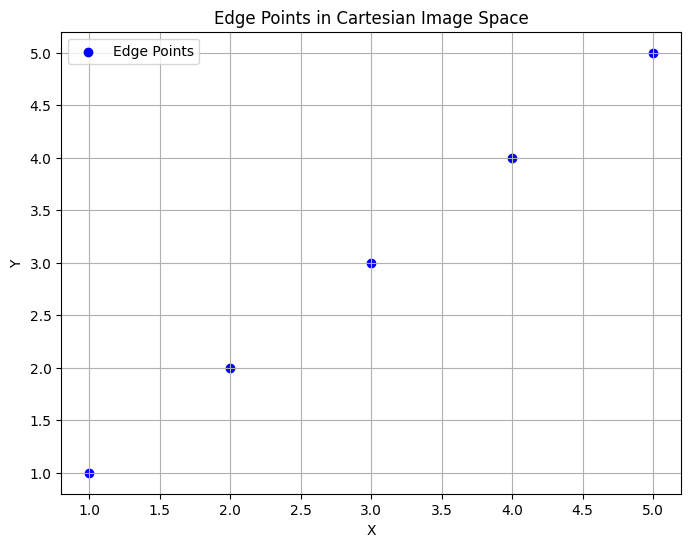

In [9]:
import matplotlib.pyplot as plt

# Some basic points for the toy problem.
all_points = [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]

# Separate the points into x and y coordinates for plotting
x_coords, y_coords = zip(*all_points)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, label='Edge Points', color='blue')  # Plot all points
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Edge Points in Cartesian Image Space')
plt.legend()
plt.grid(True)
plt.show()


#### 4.2. Hough Transform: The Parameter Space 

- Because every edge point in the Cartesian image space is represented by ($x$, $y$) coordinates, we can transform these edge points into a "*parameter space*" wherein they exist as lines.  
    - Specifically, for each edge point ($x_i$, $y_i$) in the image space, we can create a line in the parameter space defined as $b = -mx_i + y_i$.
    - In the image space, the dimensions are $X$ and $Y$. In the parameter space, the dimensions are $b$ and $m$. 

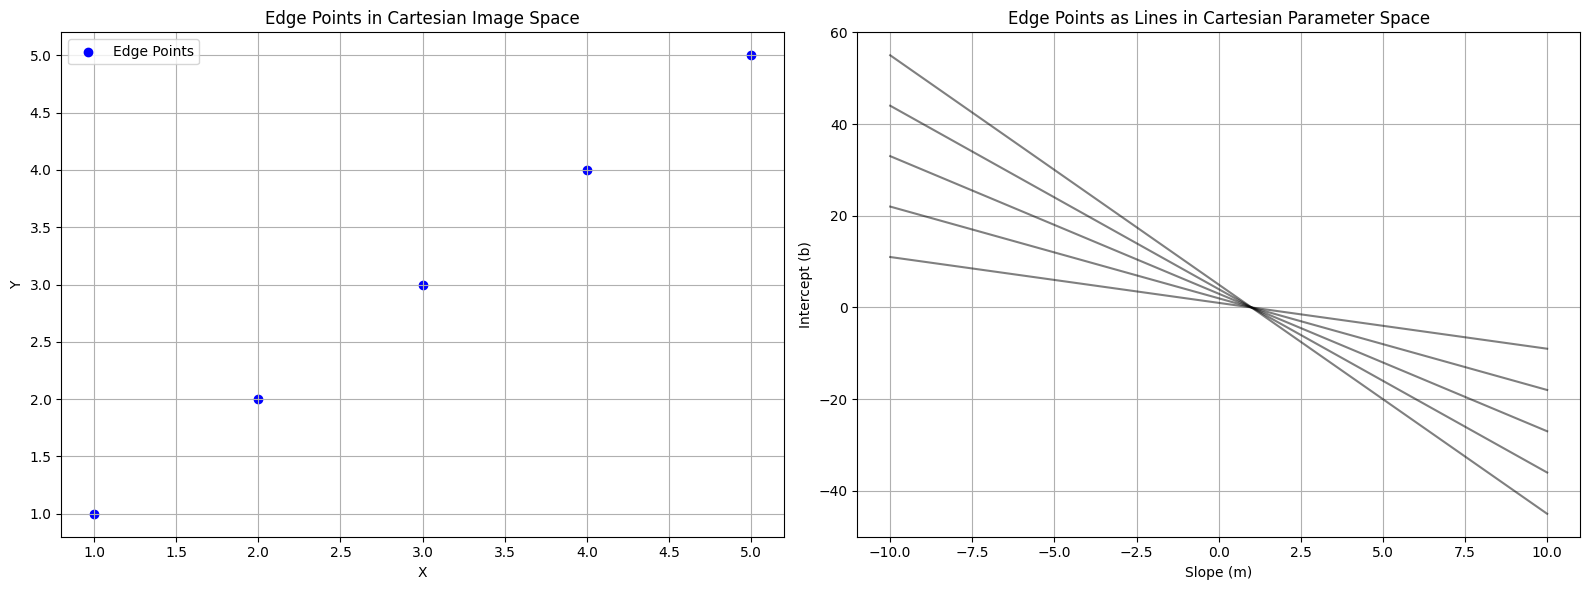

In [10]:
# Range of the parameter space
m_values = np.linspace(-10, 10, 400)

# Initialize lists to hold b values for each point
b_values_lists = []

# Calculate b values for each point and each m value, storing the results
for x, y in all_points:
    b_values = -m_values * x + y
    b_values_lists.append(b_values)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot for the Cartesian image space
axs[0].scatter(x_coords, y_coords, label='Edge Points', color='blue')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title('Edge Points in Cartesian Image Space')
axs[0].legend()
axs[0].grid(True)

# Plot for the parameter space
for b_values in b_values_lists:
    axs[1].plot(m_values, b_values, color='black', alpha=0.5)  # Plot lines in parameter space for each point
axs[1].set_xlabel('Slope (m)')
axs[1].set_ylabel('Intercept (b)')
axs[1].set_title('Edge Points as Lines in Cartesian Parameter Space')
axs[1].grid(True)
plt.tight_layout()
plt.show()

#### 4.3. Hough Transform: The Utility of Parameter Space 

- So, what's the point of doing this? Notice how in the Cartesian parameter space graph above, $5$ of the lines seem to intersect at a single point. 
    - This single point of intersection represents the values of $b^*$ and $m^*$ that parameterize the line that travels through those $5$ points in the original image space!  
    - In our simple example, we deliberately made is to that $b^* = 0$ and $m^* = 1$ for these $5$ points. 
        - As you can see in the graph below, plotting the line $y = 1 * x + 0$ in the Cartesian image space gives us a line that passes through all the $5$ points. 
        - This simple yet powerful idea that we can turn all of our edge points into lines in a parameter space and then count the number of intersections to find the best parameters for our lines in the original image space is central to the Hough Transform. 



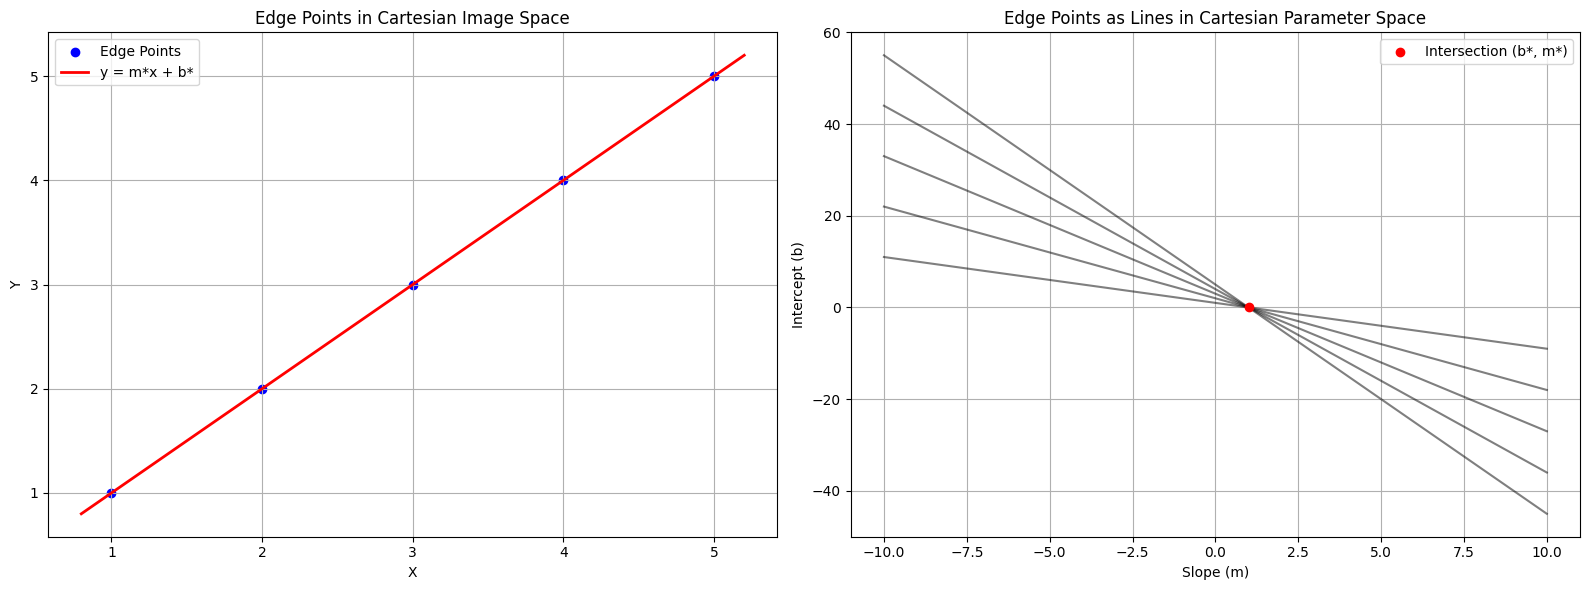

In [11]:
m_opt, b_opt = 1, 0 # The optimal slope is 1 and intercept is 0 in our example.
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot for the Cartesian image space
axs[0].scatter(x_coords, y_coords, label='Edge Points', color='blue')
# Plot the calculated line using the optimal slope and intercept in the image space
x_range = np.array(axs[0].get_xlim())
line_y = m_opt * x_range + b_opt
axs[0].plot(x_range, line_y, color='red', label='y = m*x + b*', linewidth=2)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title('Edge Points in Cartesian Image Space')
axs[0].legend()
axs[0].grid(True)

# Plot for the parameter space with lines for each point
for b_values in b_values_lists:
    axs[1].plot(m_values, b_values, color='black', alpha=0.5)
# Highlight the intersection point in the parameter space, now correctly placing only the point
axs[1].scatter(m_opt, b_opt, color='red', zorder=5, label=f'Intersection (b*, m*)')
axs[1].set_xlabel('Slope (m)')
axs[1].set_ylabel('Intercept (b)')
axs[1].set_title('Edge Points as Lines in Cartesian Parameter Space')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()



#### 4.4. Hough Transform: The Accumulator Matrix
- In the algorithm, what we do is create an accumulator matrix that represents the parameter space.
    - We put $b$ on the Y-axis and $m$ on the X-axis, just like in the above chart of our parameter space. 
    - We initialize it to $0$. 
    - Of course, the only way to represent a continous space in a table or matrix is by discretizing it, so we do that first. 
- This accumulator array can vary in size and really depends on the granularity of the discretization of the parameter space. 
    - Do we want the cells of the accumulator matrix to represent large swathes of the parameter space or not? 
    - This is really important because if it's too granular, we'll have to deal with a rather large table that can be computationally inefficient. If the discrete bins are too large, we will detect lines inaccurately. 
    - This is referred to as the "resolution." 
- So, what we do is we go through every single edge pixel in our Cartesian image space and we convert it into a line in our Cartesian parameter space. For each edge point in the image space, you calculate the parameters ($m$ and $b$) that would make a line pass through this point. In practice, you discretize this process by iterating through a set of possible $m$ values, calculate the corresponding $b$ for each $m$.
    - The space that any line occupies in the parameter space corresponds to a cross-section of cells in our accumulator array. We increment every cell that is passed through by $1$ (though some algorithms implement a patch voting system where adjacent cells in a "patch" are also incremented.)
        - This functions like a sort voting system where lines vote on ($m$, $b$) pairs. Specifically, they vote on ($m$, $b$) pairs that pass through. At the end of voting, the "peaks" will be those with the most votes. And, as you can see in the accumulator matrix below for our toy problem, the ($m$, $b$)-pair ($1$, $0$) has received $5$ votes--a vote for each line that passed through it in the Cartesian parameter space.
- The final step here is to find the local maximum. This is the point of intersection and it corresponds to the parameters ($m^*$, $b^*$) of the line that passes through the $5$ points.

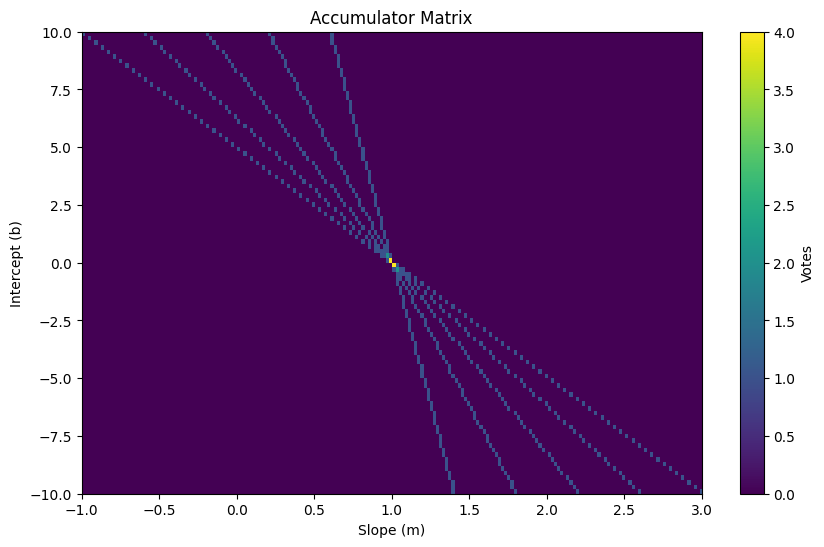

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range and resolution for m and b parameters
m_range = np.linspace(-1, 3, 100)  # Slope
b_range = np.linspace(-10, 10, 200)  # Intercept

# Initialize the accumulator matrix to zeros
accumulator = np.zeros((len(m_range), len(b_range)))

# Populate the accumulator matrix
for x, y in all_points:
    for i, m in enumerate(m_range):
        b = y - m * x  # Calculate b for this m
        # Find the closest index in b_range for this b value
        b_idx = np.abs(b_range - b).argmin()
        accumulator[i, b_idx] += 1  # Increment the accumulator cell

# Plotting the accumulator matrix
plt.figure(figsize=(10, 6))
plt.imshow(accumulator, extent=[m_range[0], m_range[-1], b_range[0], b_range[-1]], aspect='auto', origin='lower')
plt.colorbar(label='Votes')
plt.xlabel('Slope (m)')
plt.ylabel('Intercept (b)')
plt.title('Accumulator Matrix')
plt.show()


#### 4.5. Hough Transform: The Problem with Cartesian Parameter Space

- There's an obvious problem here... $m \in (-\infty, \infty)$. What this means is that our accumulator matrix may be quite large depending on our problem, which is computationally burdensome.
- Thankfully, there's an easy solution to this. Instead of using a Cartesian parameter space where $b = -mx + y$, we use a parameter space based on the polar coordinate system.
- In the polar coordinate system, a line is represented by two parameters: $\rho$ (rho) and $\theta$ (theta). Here, $\rho$ is the distance from the origin to the closest point on the straight line, and $\theta$ is the angle between the x-axis and the line connecting the origin with that closest point.
- The equation of a line in polar coordinates is given by: $\rho = x \cos(\theta) + y \sin(\theta)$
- Using $\rho$ and $\theta$ as parameters, each point in the image space votes for lines in the $\rho$-$\theta$ parameter space. This method bounds the range of both parameters: $\theta$ typically ranges from $0$ to $180$ degrees (or $0$ to $\pi$ radians), and $\rho$ is limited by the diagonal length of the image space, thus significantly reducing the size of the accumulator matrix compared to the unbounded slope in the Cartesian parameter space.
- In polar parameter space, the lines are sinusoids, so they're wavy. 

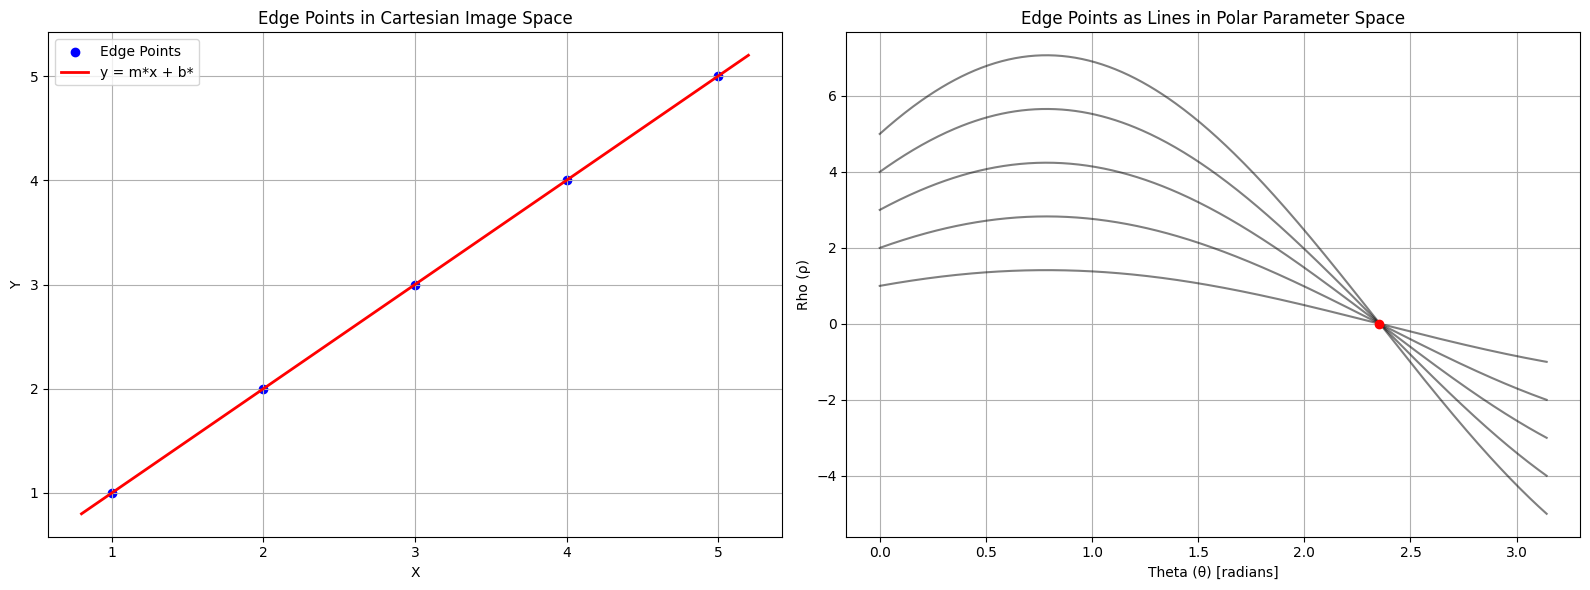

In [13]:
# Initialize figure and axes
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot for the Cartesian image space with the calculated line
axs[0].scatter(x_coords, y_coords, label='Edge Points', color='blue')
x_range = np.array(axs[0].get_xlim())
line_y = m_opt * x_range + b_opt
axs[0].plot(x_range, line_y, color='red', label='y = m*x + b*', linewidth=2)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title('Edge Points in Cartesian Image Space')
axs[0].legend()
axs[0].grid(True)

# Convert edge points to polar parameter space and plot
theta_range = np.linspace(0, np.pi, 400)

# Plotting the lines for each point in polar coordinates
for x, y in all_points:
    rho_values = x * np.cos(theta_range) + y * np.sin(theta_range)
    axs[1].plot(theta_range, rho_values, color='black', alpha=0.5)

axs[1].set_xlabel('Theta (θ) [radians]')
axs[1].set_ylabel('Rho (ρ)')
axs[1].set_title('Edge Points as Lines in Polar Parameter Space')
axs[1].scatter(2.35, 0, color='red', zorder=5, label=f'Intersection (b*, m*)')

axs[1].grid(True)

plt.tight_layout()
plt.show()

#### 4.6. Hough Transform: Polar Accumulator Matrix

- Just like in the Cartesian accumulator matrix, each cell in the polar accumulator matrix corresponds to a specific ($\rho$, $\theta$) pair. Every point in the image contributes votes to these cells based on the lines that pass through the point.


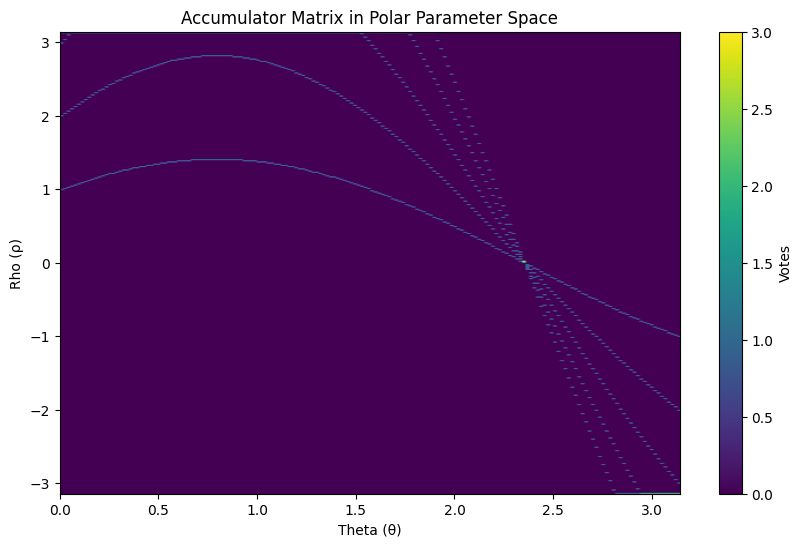

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range and resolution for theta and rho parameters
theta_range = np.linspace(0, np.pi, 180)  # Theta range from -pi to pi
rho_max = np.hypot(0,np.pi)  # Max possible rho value, diagonal of the image
rho_range = np.linspace(-rho_max, rho_max, 400)  # Rho

# Initialize the accumulator matrix to zeros
accumulator = np.zeros((len(rho_range), len(theta_range)))

# Assume all_points is a list of (x, y) tuples of edge points
for x, y in all_points:
    for i, theta in enumerate(theta_range):
        rho = x * np.cos(theta) + y * np.sin(theta)  # Calculate rho for this theta
        # Find the closest index in rho_range for this rho value
        rho_idx = np.abs(rho_range - rho).argmin()
        accumulator[rho_idx, i] += 1  # Increment the accumulator cell

# Plotting the accumulator matrix
plt.figure(figsize=(10, 6))
plt.imshow(accumulator, extent=[theta_range[0], theta_range[-1], rho_range[0], rho_range[-1]], aspect='auto', origin='lower')
plt.colorbar(label='Votes')
plt.xlabel('Theta (θ)')
plt.ylabel('Rho (ρ)')
plt.title('Accumulator Matrix in Polar Parameter Space')
plt.show()

# Note: The plotting of edge points and lines in Cartesian and polar spaces was correctly shown in your provided code.
# This snippet focuses on creating and displaying the accumulator matrix for polar space.


In [15]:
image = cv2.imread("images/cluttera2.jpg", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
g = gaussian_kernel() # Create a Gaussian kernel.  
smoothed_image = scipy.signal.convolve2d(image, g) # Smooth the image. 
smoothed_image = np.pad(smoothed_image, pad_width=1, mode='constant', constant_values=0) # Zero-pad the smoothed image. 
img_edges = canny_edge_detector(smoothed_image, 20, 40) # Apply Canny edge detection and retieve the edge image.

#### 4.7. Hough Transform: **`hough_line()`**

The line of code `h, theta, d = hough_line(img_edges, theta=tested_angles)` performs the Hough Transform on an image with pre-detected edges (`img_edges`) over a specified range of angles (`tested_angles`).

- **`hough_line(img_edges, theta=tested_angles)`**: 
  - `img_edges`: Represents the input image where edges have been detected. Only non-zero values in this image are considered as candidates for forming lines.
  - `theta=tested_angles`: Specifies the angles, in radians, at which the Hough Transform should be computed. This gives us control over the discretization process and, as I mentioned before, will control the "resolution".

- The function returns three components:
  - `h`: A 2-D ndarray (`h_{space}`) representing the Hough space accumulator. Each element h[$\rho$][$\theta$] counts votes for the presence of a line at distance $\rho$ from the origin and angle $\theta$.
  - `theta`: An array of angles in radians that were tested during the transform. These angles correspond to the columns in `h_{space}` and are derived from `tested_angles`.
  - `d`: An array of distances, where each distance corresponds to a potential line detected in the image. These distances represent the minimal algebraic distance from the origin to the detected lines.

The unpacking `h, theta, d` assigns the Hough space accumulator to `h`, the angles used in the computation to `theta`, and the distances to detected lines to `d`. 


In [16]:
# Classic straight-line Hough transform
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(img_edges, theta=tested_angles)

#### 4.8. Hough Transform: Identifying Peaks in the Accumulator Matrix with a Peak Finding Algorithm

- In the previous step, we explained that the `hough_line()` function was executing the line detection algorithm we had just finished thoroughly explaining. 
- After this step, we have to determine which "peaks" in the accumulator matrix represent lines. 
    - This is usually done with a peak finder algorithm. 
- The particular peak finding algorithm that the code employs is non-maximum suppression, which we spoke about earlier in this notebook. 

### `hough_line_peaks()` 

The function detects the most significant lines within a Hough transform space, utilizing non-maximum suppression across both the distance and angle dimensions to pinpoint peak values. This function is meant to be fed the outputs generated by the `hough_line()` function.

- Returns a tuple `(accum, angles, dists)` that includes the peak intensities within the Hough space, alongside their corresponding angles and distances, signifying the detected lines of greatest significance.

In [17]:
accum, angles, dists = hough_line_peaks(h,theta,d,threshold=1,num_peaks=10)

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

# Running code from Lab 3

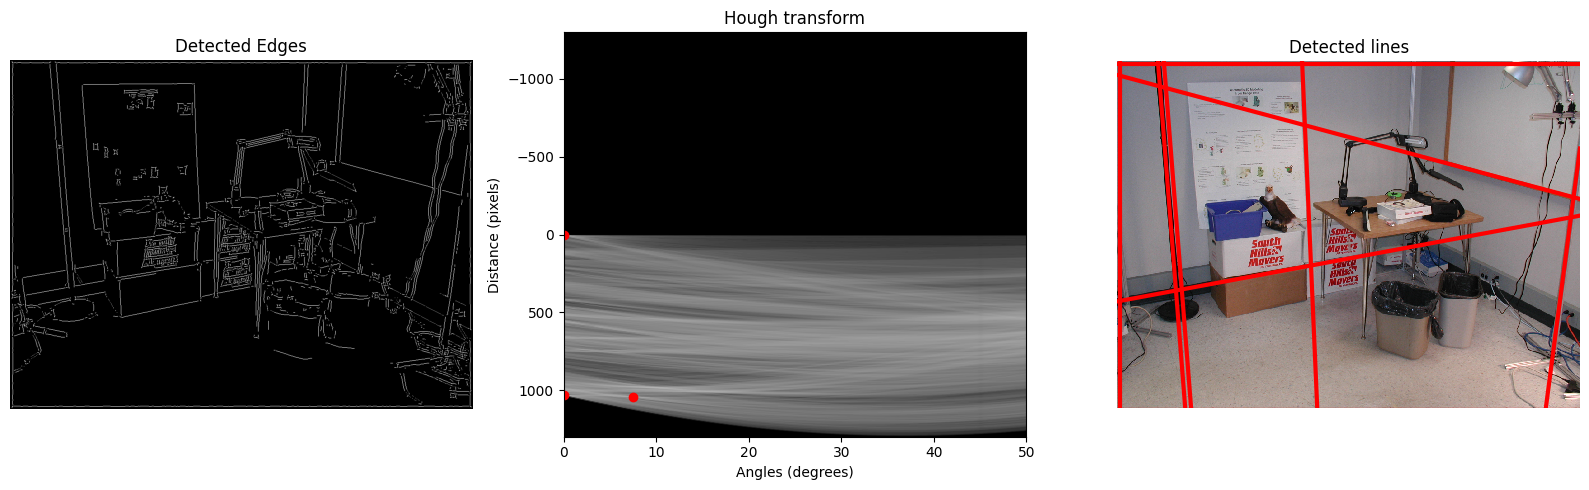

In [18]:


# Configure the figure
fig, axes = plt.subplots(1, 3,figsize=(16, 5))
ax = axes.ravel()

ax[0].imshow(img_edges, cmap=cm.gray)
ax[0].set_title('Detected Edges')
ax[0].set_axis_off()
# Plot each of the lines on the hough transform
for i in range(0,len(angles)):
    ax[1].plot(np.rad2deg(angles[i]),dists[i],'ro')

ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray,aspect=0.1)

ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')

ax[1].axis('auto')
ax[1].set_xlim(0,50)

# Plot Figure 3: Detected Lines
for i in range(0,len(angles)):
    (x0, y0) = dists[i] * np.array([np.cos(angles[i]), np.sin(angles[i])])
    ax[2].axline((x0, y0),slope=np.tan(angles[i] + np.pi/2), color="red", linewidth=3)

ax[2].set_ylim((img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

io.imshow(img)
plt.show()

# Task 2

"What is the effect of increasing/decreasing the required number of peaks in ‘houghpeaks’?"



In [19]:
# Increase num_peaks by an order of magnitude, all else being equal. 
accum, angles, dists = hough_line_peaks(h,theta,d,threshold=1,num_peaks=100)

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

Increasing the number of Hough Peaks results in an increase in the number of lines detected. This makes sense because peaks represent intersections of several lines in the Hough/parameter space. Each of these intersections corresponds to parameters that form a line in the original image space. When we increase the numer of allowed peaks, we increase the number of intersections. When we increase the number of intersections, we increase the number of lines that will be detected in the original image space. 

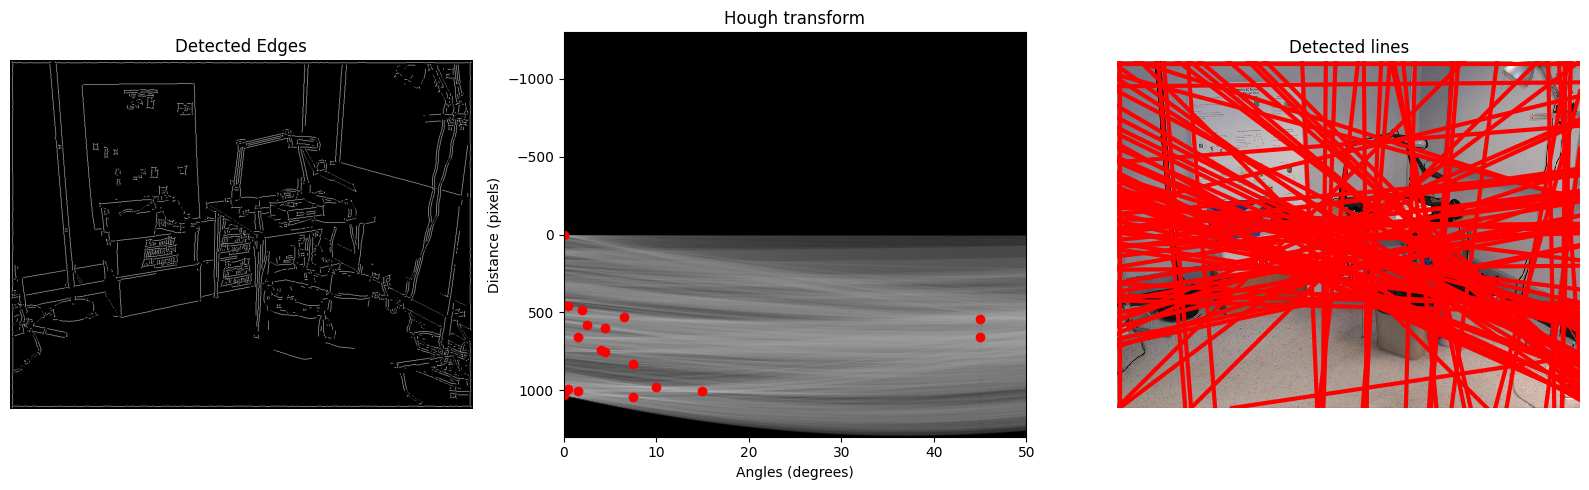

In [20]:


# Configure the figure
fig, axes = plt.subplots(1, 3,figsize=(16, 5))
ax = axes.ravel()

ax[0].imshow(img_edges, cmap=cm.gray)
ax[0].set_title('Detected Edges')
ax[0].set_axis_off()
# Plot each of the lines on the hough transform
for i in range(0,len(angles)):
    ax[1].plot(np.rad2deg(angles[i]),dists[i],'ro')

ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray,aspect=0.1)

ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')

ax[1].axis('auto')
ax[1].set_xlim(0,50)

# Plot Figure 3: Detected Lines
for i in range(0,len(angles)):
    (x0, y0) = dists[i] * np.array([np.cos(angles[i]), np.sin(angles[i])])
    ax[2].axline((x0, y0),slope=np.tan(angles[i] + np.pi/2), color="red", linewidth=3)

ax[2].set_ylim((img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

io.imshow(img)
plt.show()

In [21]:
# Decrease num_peaks by an order of magnitude, all else being equal. 
accum, angles, dists = hough_line_peaks(h,theta,d,threshold=1,num_peaks=1)

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

Perhaps unsurprisingly, the logic cuts both ways. When we decrease the number of peaks allowed, we are decreasing the number of intersections. When there are only a small number of intersections, there only a small number of lines will be detected. In this extreme example, we set num_peaks to 1. This results in only a single line being detected in the original image space!

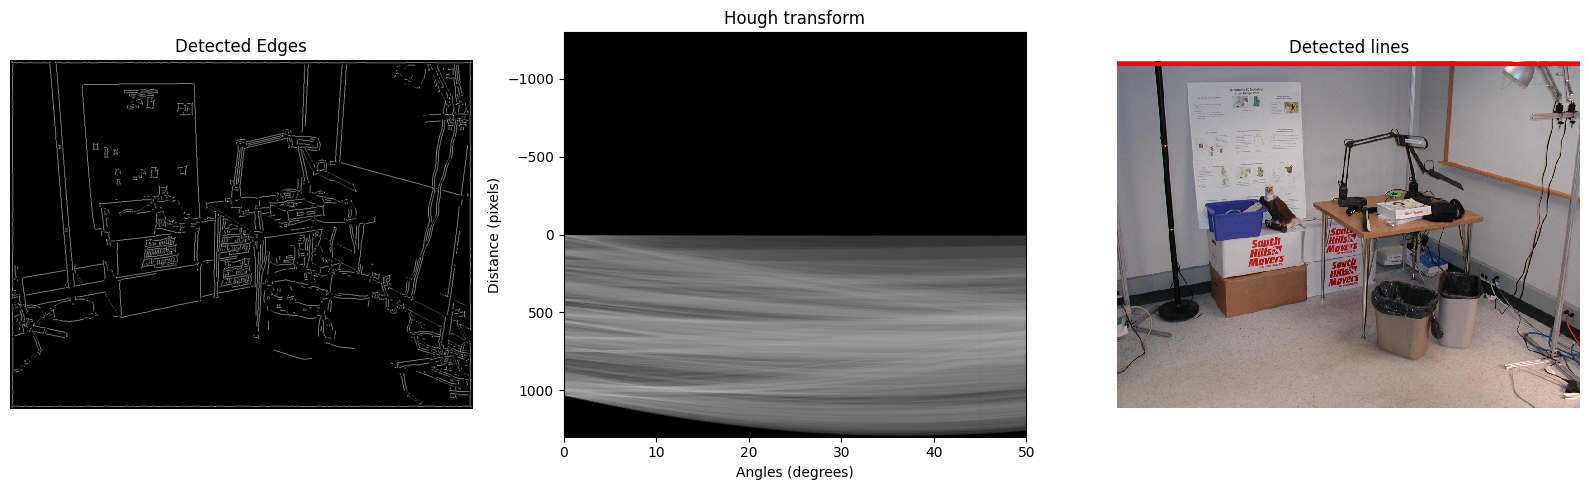

In [22]:


# Configure the figure
fig, axes = plt.subplots(1, 3,figsize=(16, 5))
ax = axes.ravel()

ax[0].imshow(img_edges, cmap=cm.gray)
ax[0].set_title('Detected Edges')
ax[0].set_axis_off()
# Plot each of the lines on the hough transform
for i in range(0,len(angles)):
    ax[1].plot(np.rad2deg(angles[i]),dists[i],'ro')

ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray,aspect=0.1)

ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')

ax[1].axis('auto')
ax[1].set_xlim(0,50)

# Plot Figure 3: Detected Lines
for i in range(0,len(angles)):
    (x0, y0) = dists[i] * np.array([np.cos(angles[i]), np.sin(angles[i])])
    ax[2].axline((x0, y0),slope=np.tan(angles[i] + np.pi/2), color="red", linewidth=3)

ax[2].set_ylim((img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

io.imshow(img)
plt.show()

# Task 3

"Replace the Canny Edge detector with other algorithms. Which one do you think performs best and why?"



### 3.0 Canny

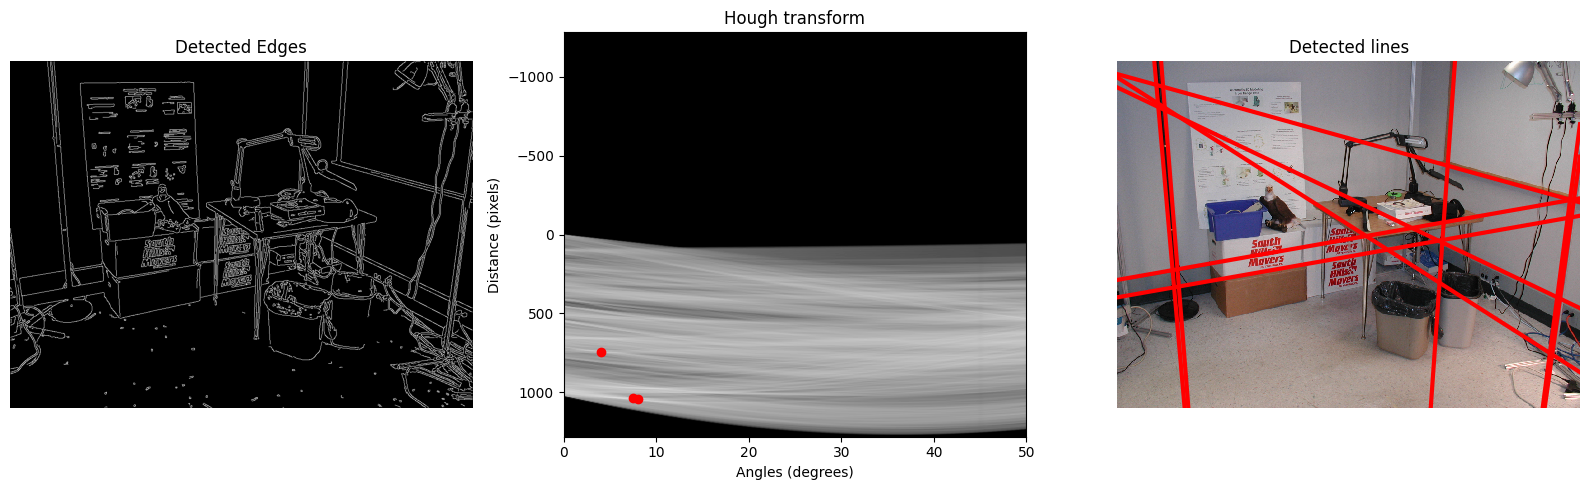

In [23]:


## First we will read the image and find edges
# Read image
img = io.imread('images/cluttera2.jpg')

# The image is RGB and we need to convert to grayscale
img_grey = rgb2gray(img)

# Apply your favourite edge detector: Here I am using Built-in Canny
img_edges = canny(img_grey)

# Configure the figure
fig, axes = plt.subplots(1, 3,figsize=(16, 5))
ax = axes.ravel()

ax[0].imshow(img_edges, cmap=cm.gray)
ax[0].set_title('Detected Edges')
ax[0].set_axis_off()

# Classic straight-line Hough transform
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(img_edges, theta=tested_angles)

accum, angles, dists = hough_line_peaks(h,theta,d,threshold=1,num_peaks=10)

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

# Plot each of the lines on the hough transform
for i in range(0,len(angles)):
    ax[1].plot(np.rad2deg(angles[i]),dists[i],'ro')

ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray,aspect=0.1)

ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')

ax[1].axis('auto')
ax[1].set_xlim(0,50)

# Plot Figure 3: Detected Lines
for i in range(0,len(angles)):
    (x0, y0) = dists[i] * np.array([np.cos(angles[i]), np.sin(angles[i])])
    ax[2].axline((x0, y0),slope=np.tan(angles[i] + np.pi/2), color="red", linewidth=3)

ax[2].set_ylim((img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

io.imshow(img)
plt.show()

### 3.1. Roberts 

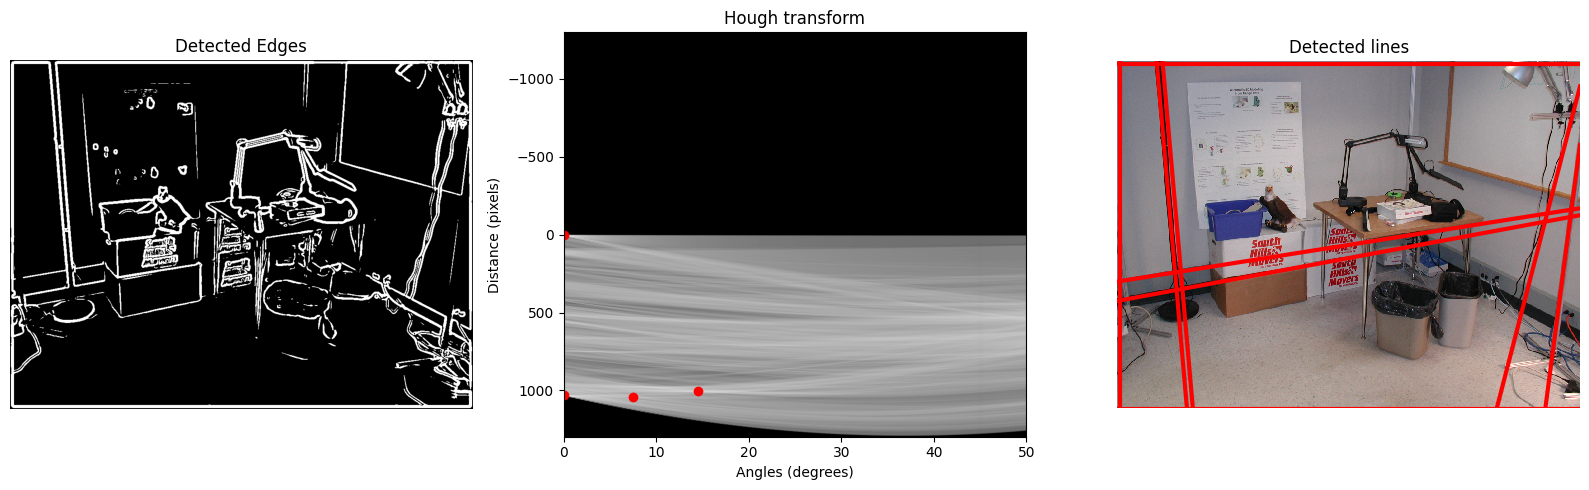

In [24]:
roberts_x = np.array([[1, 0],
                     [0, -1]])

roberts_y = np.sort(roberts_x, axis=1)

image = cv2.imread("images/cluttera2.jpg", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
g = gaussian_kernel() # Create a Gaussian kernel.  
smoothed_image = scipy.signal.convolve2d(image, g) # Smooth the image. 
smoothed_image = np.pad(smoothed_image, pad_width=1, mode='constant', constant_values=0) # Zero-pad the smoothed image. 

G_x = scipy.signal.convolve2d(smoothed_image, roberts_x)
G_y = scipy.signal.convolve2d(smoothed_image, roberts_y)
magnitude = magnitude_img(G_x, G_y) 
img_edges = magnitude > 10

# Configure the figure
fig, axes = plt.subplots(1, 3,figsize=(16, 5))
ax = axes.ravel()

ax[0].imshow(img_edges, cmap=cm.gray)
ax[0].set_title('Detected Edges')
ax[0].set_axis_off()

# Classic straight-line Hough transform
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(img_edges, theta=tested_angles)

accum, angles, dists = hough_line_peaks(h,theta,d,threshold=1,num_peaks=10)

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

# Plot each of the lines on the hough transform
for i in range(0,len(angles)):
    ax[1].plot(np.rad2deg(angles[i]),dists[i],'ro')

ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray,aspect=0.1)

ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')

ax[1].axis('auto')
ax[1].set_xlim(0,50)

# Plot Figure 3: Detected Lines
for i in range(0,len(angles)):
    (x0, y0) = dists[i] * np.array([np.cos(angles[i]), np.sin(angles[i])])
    ax[2].axline((x0, y0),slope=np.tan(angles[i] + np.pi/2), color="red", linewidth=3)

ax[2].set_ylim((img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

io.imshow(img)
plt.show()

### 3.2. Laplacian of Gaussian

In [25]:
def zero_crossing(log_image: NDArray[np.float64], threshold: float = 0.1) -> NDArray[np.float64]:
    """
    Detect zero crossings in an LoG filtered image.
    A zero crossing occurs if the sign of the value of a pixel's neighbor is different,
    and the magnitude is above a certain threshold.
    """
    log_image = np.pad(log_image, pad_width=1, mode='constant', constant_values=0)

    # Initialize the edge image
    edges = np.zeros_like(log_image)
    # Get the dimensions of the LoG image
    n, m = log_image.shape

    # Iterate over the image (excluding the borders, assumes zero-padding)
    for x in range(1, n-1):
        for y in range(1, m-1):
            # Get the neighborhood of the pixel
            patch = log_image[x-1:x+2, y-1:y+2]
            # Find the maximum and minimum
            pmax, pmin = patch.max(), patch.min()
            # Check if it crosses zero and if the magnitude is above the threshold
            if pmax > threshold and pmin < -threshold:
                # Mark as edge
                edges[x, y] = 1
    return edges


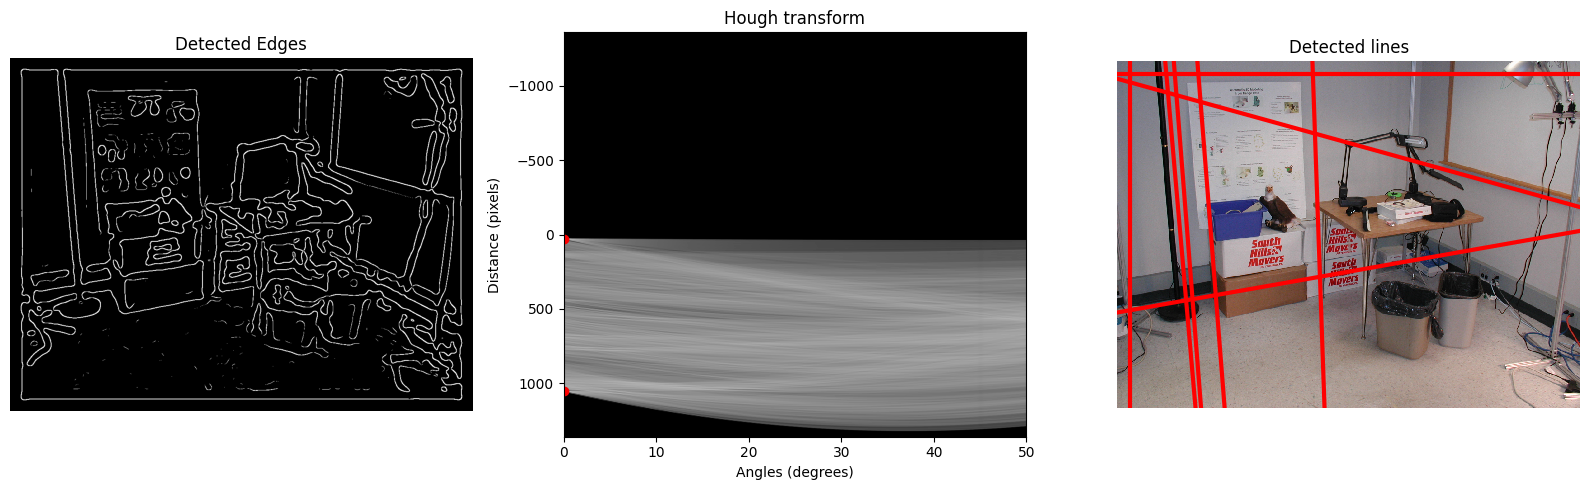

In [26]:
g = gaussian_kernel(53, 7)
image = cv2.imread("images/cluttera2.jpg", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 

laplacian_kernel = np.array([[-1,-1,-1],
                    [-1, 8, -1],
                    [-1,-1,-1]])

#Laplacian of Gaussian (LoG)
LoG = scipy.signal.convolve2d(g, laplacian_kernel)
laplacian_image = scipy.signal.convolve2d(image, LoG) #Larger matrix on the left. 

# # Find zero-crossings
img_edges = zero_crossing(laplacian_image, .03)

# Configure the figure
fig, axes = plt.subplots(1, 3,figsize=(16, 5))
ax = axes.ravel()

ax[0].imshow(img_edges, cmap=cm.gray)
ax[0].set_title('Detected Edges')
ax[0].set_axis_off()

# Classic straight-line Hough transform
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(img_edges, theta=tested_angles)

accum, angles, dists = hough_line_peaks(h,theta,d,threshold=1,num_peaks=10)

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

# Plot each of the lines on the hough transform
for i in range(0,len(angles)):
    ax[1].plot(np.rad2deg(angles[i]),dists[i],'ro')

ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray,aspect=0.1)

ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')

ax[1].axis('auto')
ax[1].set_xlim(0,50)

# Plot Figure 3: Detected Lines
for i in range(0,len(angles)):
    (x0, y0) = dists[i] * np.array([np.cos(angles[i]), np.sin(angles[i])])
    ax[2].axline((x0, y0),slope=np.tan(angles[i] + np.pi/2), color="red", linewidth=3)

ax[2].set_ylim((img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

io.imshow(img)
plt.show()

The best performance came from the Canny detection algorithm. There are several reasons for this. 

1. The Roberts operator is more sensitive to noise compared to the Canny method. I tried to account for this by smoothing the image beforehand. 
2. The Roberts operator primarily detects edges at $45$-degree angles. This limitation means that it does not capture all relevant edges in an image as effectively as the Canny detector. 
3. The Roberts operator does not have a mechanism to perform non-max suppression, so the edges are thick. 
4. LoG is also sensitive to noise, even though it incorporates a Gaussian blur to reduce this sensitivity before applying the Laplacian. The Canny edge detector, with its multi-stage process including noise reduction, gradient calculation, non-maximum suppression, and hysteresis thresholding, is generally more robust against noise.
5. The LoG operator can sometimes produce edges that are thicker or more diffuse (as you can see) than those detected by the Canny method. This can make it more challenging to precisely locate edges, especially in images with fine details.
6. LoG uses a zero-crossing method to detect edges, which can be less flexible and less effective in distinguishing between strong and weak edges compared to Canny's dual-thresholding approach, which better differentiates between true edges and noise.
7. The Canny method uses gradient direction to more accurately identify edge orientation, providing superior detection of edges irrespective of their orientation.
8. Through non-maximum suppression and hysteresis thresholding, Canny effectively distinguishes between strong and weak edges, allowing for more nuanced edge detection and reducing the likelihood of detecting false edges.

# Task 4

Examine the guide for Probabilistic Hough Transform: https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html#probabilistic-hough-transform. Apply probabilistic hough transform to the provided image. Describe in the report how this algorithm works, particularly when finding the start/finish of a line.

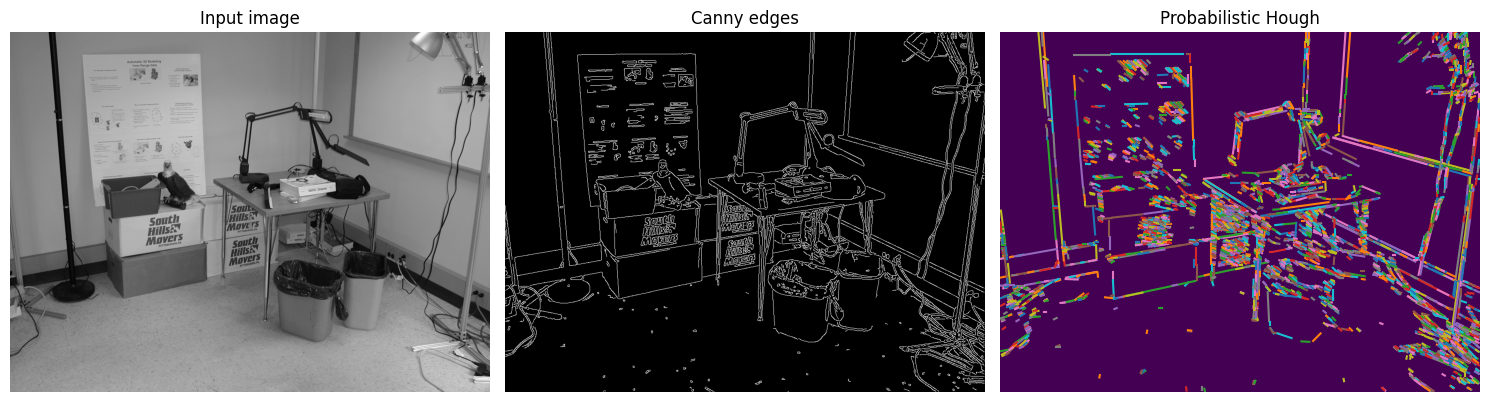

In [27]:
from skimage.transform import probabilistic_hough_line


## First we will read the image and find edges
# Read image
img = io.imread('images/cluttera2.jpg')

# The image is RGB and we need to convert to grayscale
img_grey = rgb2gray(img)

# Apply your favourite edge detector: Here I am using Built-in Canny
img_edges = canny(img_grey)

lines = probabilistic_hough_line(img_edges, threshold=10, line_length=5,
                                 line_gap=3)


fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(img_edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(img_edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

The Probabilistic Hough Transform is an optimization of the Hough Transform algorithm for line detection. It operates by randomly sampling points from the input edge image and computing the potential lines that could pass through these points. This method is particularly efficient in finding the start and end points of lines by only considering a subset of points, which significantly reduces computational complexity. It allows for the detection of line segments in the image by specifying parameters like the minimum line length and the maximum gap between segments to be bridged, making it more adaptable to various image contexts compared to the standard Hough Transform. It dynamically selects a subset of points from edge-detected images for voting on potential lines, thereby reducing computational requirements. It uniquely identifies the start and end of line segments by "walking" along connected components, adjusting the line acceptance threshold based on the number of votes cast. This approach allows for the efficient detection of lines of varying lengths, with the algorithm prioritizing longer, more salient lines before shorter ones, making it particularly suited for real-time applications where processing time is fixed.